# UCS654: Assignment  - 2

---

**Title:** Learning Probability Density Functions using data only

**Dataset:** Consider NO2 as feature ($x$).

**Dataset Link:** https://www.kaggle.com/datasets/shrutibhargava94/india-air-quality-data

**Objective:** To learn an unknown probability density function of a transformed random variable using a
Generative Adversarial Network (GAN).

In [3]:
%load_ext cudf.pandas

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
import csv

from scipy.optimize import curve_fit
from scipy.stats import norm, probplot

%matplotlib inline

## Loading Dataset
---

In [5]:
dataset_handle = "shrutibhargava94/india-air-quality-data"

In [6]:
import os

# --- Configuration ---
# The folder name in /kaggle/input usually matches the slug (the part after the slash)
dataset_slug = dataset_handle.split("/")[-1]
kaggle_internal_path = f"/kaggle/input/{dataset_slug}"

if os.path.exists(kaggle_internal_path):
    # Scenario 1: We are on Kaggle and the dataset is already linked
    print(f"✅ Detected Kaggle environment. Using linked data at: {kaggle_internal_path}")
    path = kaggle_internal_path
else:
    # Scenario 2: We are on Colab, Local, or Kaggle (without linked data)
    import kagglehub
    print(f"⬇️ Downloading dataset via kagglehub...")
    path = kagglehub.dataset_download(dataset_handle)

print(f"📂 FINAL DATA PATH: {path}")

⬇️ Downloading dataset via kagglehub...


100%|██████████| 5.22M/5.22M [00:00<00:00, 114MB/s]

Extracting files...


📂 FINAL DATA PATH: /root/.cache/kagglehub/datasets/shrutibhargava94/india-air-quality-data/versions/1


In [7]:
df = pd.read_csv(path + "/data.csv", usecols=["no2"], encoding="cp1252")
df.head()

,no2
0,17.4
1,7.0
2,28.5
3,14.7
4,7.5


In [8]:
df.describe()

,no2
count,419509.000000
mean,25.809623
std,18.503086
min,0.000000
25%,14.000000
50%,22.000000
75%,32.200000
max,876.000000


## Cleaning Data
---

In [9]:
# Checking invalid negative concentrations
(df.dropna() < 0).sum()

,0
no2,0


In [10]:
# Checking for invalid infinities
np.isinf(df.dropna()).sum()

np.int64(0)

In [11]:
# Checking for nulls

if df.isna().any().any():
    na_num = df.isna().sum().to_numpy()[0]
    na_pct = (na_num / df.shape[0]) * 100

    print(f"Number of null values: {na_num}")
    print(f"Percentage of null values: {na_pct:.2f}%")
else:
    print("No null values.")

Number of null values: 16233
Percentage of null values: 3.73%


[]

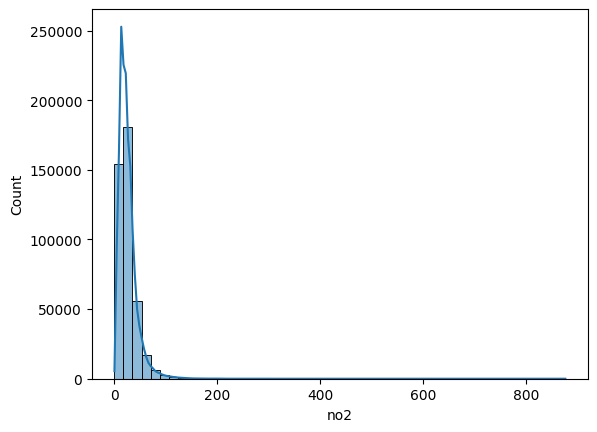

In [12]:
# Plotting histogram
sns.histplot(x="no2", data=df.dropna(), kde=True, bins=50)
plt.plot()

In [14]:
log_df

array([[2.91235066],
       [2.07944154],
       [3.38439026],
       ...,
       [3.8286414 ],
       [3.93182563],
       [3.8501476 ]])

[]

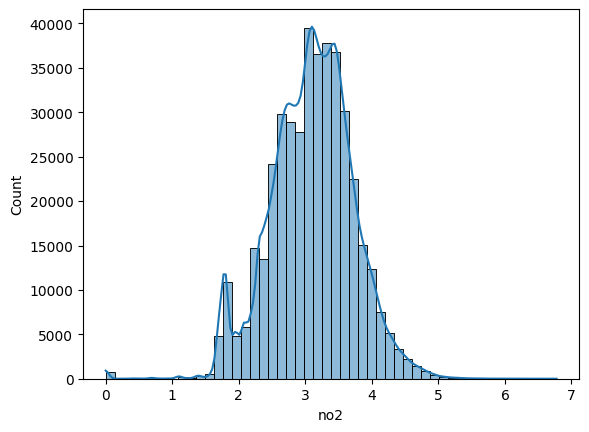

In [15]:
# Performing log-transform on heavily right skewed data
log_df = df.dropna().transform(np.log1p)
sns.histplot(x="no2", data=log_df, kde=True, bins=50)
plt.plot()

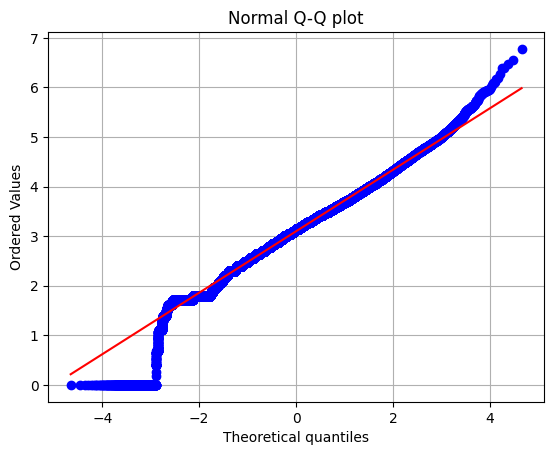

In [16]:
# Q-Q plot of log-transformed data (analysing closeness with Gaussian curve)

probplot(log_df["no2"], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Ordered Values")
plt.grid(True)
plt.show()

Best (simple) way to impute: **Drop null values**

In [17]:
# Dropping NaN

df_dropna = df.dropna()

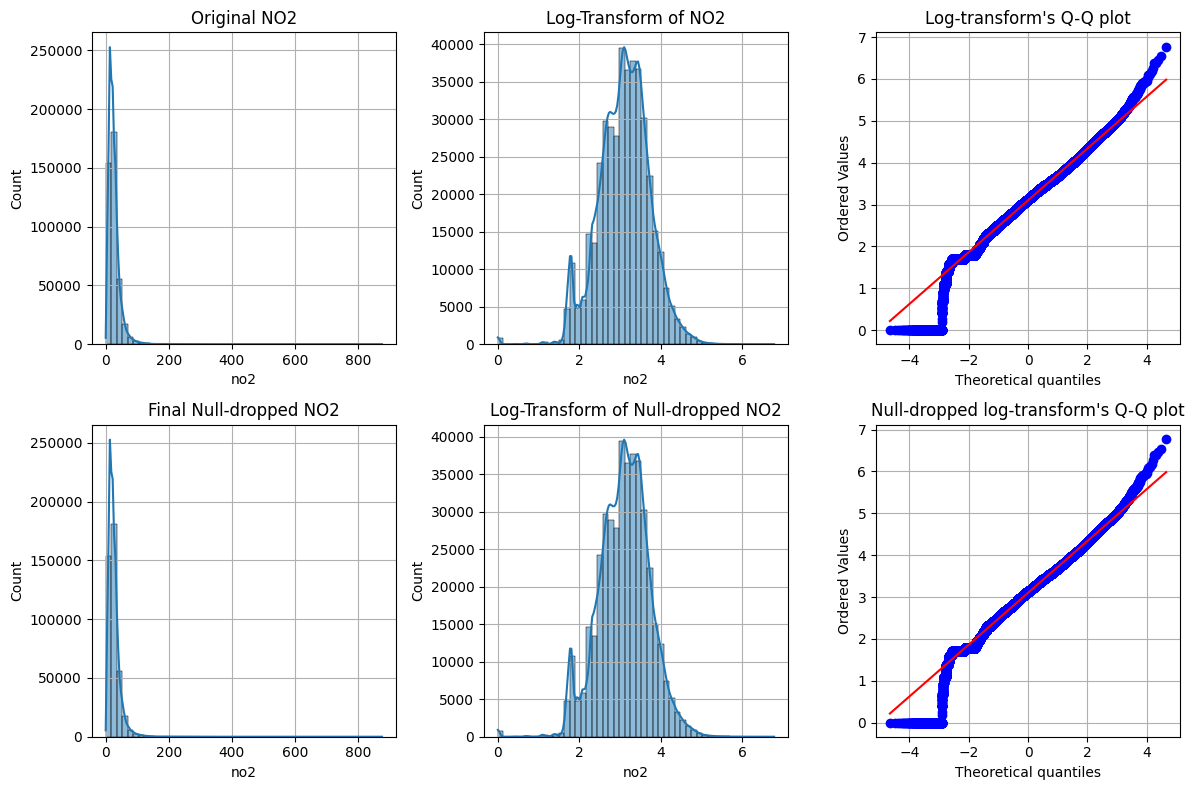

In [22]:
# Plotting imputed distribution
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

sns.histplot(x="no2", data=df, kde=True, bins=50, ax=axs[0, 0])
axs[0, 0].set_title("Original NO2")
axs[0, 0].grid(True)

sns.histplot(x="no2", data=log_df, kde=True, bins=50, ax=axs[0, 1])
axs[0, 1].set_title("Log-Transform of NO2")
axs[0, 1].grid(True)

probplot(log_df["no2"], dist="norm", plot=axs[0, 2])
axs[0, 2].set_title("Log-transform's Q-Q plot")
axs[0, 2].set_xlabel("Theoretical quantiles")
axs[0, 2].set_ylabel("Ordered Values")
axs[0, 2].grid(True)

sns.histplot(x="no2", data=df_dropna, kde=True, bins=50, ax=axs[1, 0])
axs[1, 0].set_title("Final Null-dropped NO2")
axs[1, 0].grid(True)

sns.histplot(x="no2", data=df_dropna.transform(np.log1p), kde=True, bins=50, ax=axs[1, 1])
axs[1, 1].set_title("Log-Transform of Null-dropped NO2")
axs[1, 1].grid(True)

probplot(df_dropna.transform(np.log1p)["no2"], dist="norm", plot=axs[1, 2])
axs[1, 2].set_title("Null-dropped log-transform's Q-Q plot")
axs[1, 2].set_xlabel("Theoretical quantiles")
axs[1, 2].set_ylabel("Ordered Values")
axs[1, 2].grid(True)

plt.tight_layout()
plt.show()

The Q-Q plots in the source identify two distinct failures of normality in the data:

 - **The Left-Tail "Floor" (Data Censoring):** Observing the bottom-left of the Q-Q plots, we see the blue ordered values form a horizontal flat line at y ≈ 0. This indicates that a massive cluster of data points has the exact same minimum value. In air quality data, this physically represents the "floor" of the sensor; concentrations cannot be negative, and low concentrations likely register as 0 or the minimum detection limit. The theoretical Gaussian distribution expects tails that extend to negative infinity; our data hits a hard wall at zero, creating this artifact.


 - **The Right-Tail Divergence (Extreme Outliers):** Observing the top-right of the Q-Q plots, we see the blue dots curve sharply upward away from the red theoretical line. This is a "heavy tail." It means the dataset contains extreme pollution events (very high NO2 values) that occur far more frequently than a standard Normal Distribution would predict.

[]

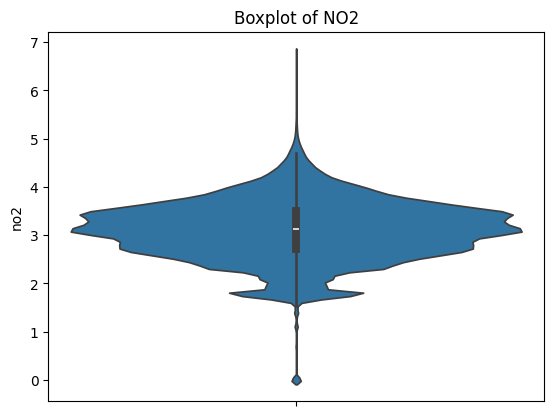

In [23]:
# Analysing 'lognormal'-ness of NO2 conc

sns.violinplot(y=np.log1p(df_dropna["no2"]), inner="box")
plt.title("Boxplot of NO2")
plt.plot()

In [24]:
df_final = df_dropna

## Tasks to be performed

---

In [25]:
x = df_final["no2"].to_numpy().reshape(-1)
x.shape

(419509,)

### Step-1: Transform x into z

---

Transform each value of x into z using the transformation function given below.

$$
    z = T_r(x) = x + a_r\sin(b_rx)
$$

where $a_r = 0.05 * (r\bmod{7})$, $b_r = 0.3 * (r\bmod{5} + 1)$

where, $\bmod$ returns remainder and $r$ is your UNIVERSITY ROLL NUMBER.

In [26]:
r = 102303754

In [27]:
a = 0.05 * (r % 7)
b = 0.3 * ((r % 5) + 1)

print(f"a = {a}")
print(f"b = {b}")

a = 0.0
b = 1.5


In [28]:
z = x + (a * np.sin(b * x))
print(z)

[17.4  7.  28.5 ... 45.  50.  46. ]


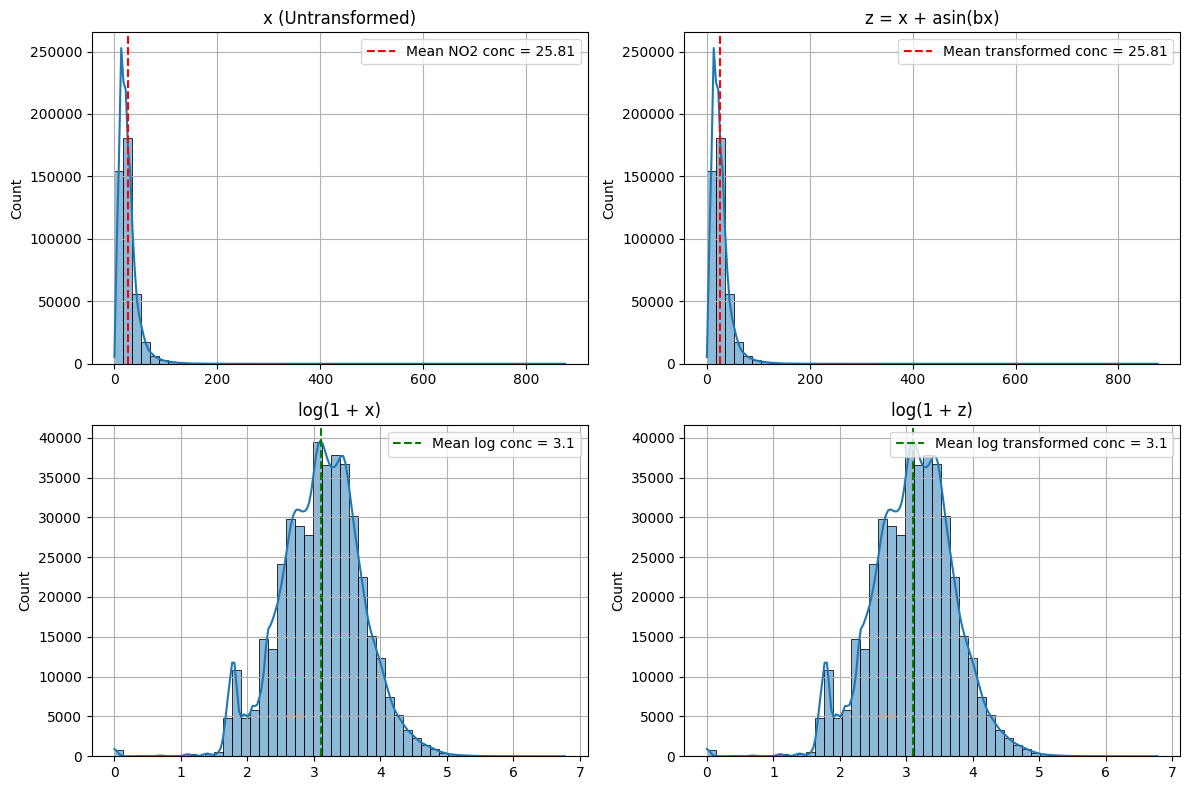

In [29]:
# Comparing x & z

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(x, kde=True, bins=50, ax=axs[0, 0])
axs[0, 0].axvline(x=x.mean(), color="red", linestyle="--", label=f"Mean NO2 conc = {x.mean():.2f}")
axs[0, 0].legend()
axs[0, 0].set_title("x (Untransformed)")
axs[0, 0].grid(True)

sns.histplot(z, kde=True, bins=50, ax=axs[0, 1])
axs[0, 1].axvline(x=z.mean(), color="red", linestyle="--", label=f"Mean transformed conc = {z.mean():.2f}")
axs[0, 1].legend()
axs[0, 1].set_title("z = x + asin(bx)")
axs[0, 1].grid(True)

sns.histplot(np.log1p(x), kde=True, bins=50, ax=axs[1, 0])
axs[1, 0].axvline(x=np.log1p(x).mean(), color="green", linestyle="--", label=f"Mean log conc = {np.log1p(x).mean():.1f}")
axs[1, 0].legend()
axs[1, 0].set_title("log(1 + x)")
axs[1, 0].grid(True)

sns.histplot(np.log1p(z), kde=True, bins=50, ax=axs[1, 1])
axs[1, 1].axvline(x=np.log1p(z).mean(), color="green", linestyle="--", label=f"Mean log transformed conc = {np.log1p(z).mean():.1f}")
axs[1, 1].legend()
axs[1, 1].set_title("log(1 + z)")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

### Step-2: PDF Estimation using GAN (Core Task)

---

In this assignment, no analytical form of the probability density function is given.

You are required to:
1. Assume that the transformed variable ($z$) is sampled from an unknown distribution
2. Design and train a Generative Adversarial Network (GAN) to learn this distribution
3. Use the generator network to implicitly model the probability density of ($z$)

**Important Notes**
- The GAN must learn the distribution only from samples of $z$
- No parametric PDF (Gaussian, exponential, etc.) should be assumed
- The discriminator should distinguish between:
  - Real samples: $z$
  - Fake samples: $z_f = G(error)$, where error follows $N(0,1)$

#### 1. Training on $z$

Maximum Likelihood Estimation (MLE) is a statistical method used to estimate the parameters of a probability distribution by maximizing the likelihood that the observed data were generated by the assumed model.

Let

$$
    X = {x_1, x_2, \dots, x_n}
$$

be i.i.d. samples drawn from a probability distribution with parameter vector $\theta$.

The **likelihood function** is defined as:

$$
    \mathcal{L}(\theta \mid X) = \prod_{i=1}^{n} p(x_i \mid \theta)
$$


The MLE is obtained by:

$$
    \hat{\theta}_{\text{MLE}} = \arg\max_{\theta} \mathcal{L}(\theta \mid X)
$$


Since the logarithm is monotonic, we maximize the **log-likelihood** instead:

$$
    \ell(\theta) = \sum_{i=1}^{n} \log p(x_i \mid \theta)
$$


Thus, to maximize this likelihood $\ell(θ)$, we **differentiate** w.r.t. $\theta$:
$$
   \frac{\partial \ell(\theta)}{\partial \theta} = 0
$$

and then **solve for $θ$** to obtain $\hat{\theta}_{\text{MLE}}$

Finally, we **verify** the solution corresponds to a maximum (second derivative test)

**Example: MLE for Normal Distribution**

Assuming $x_i \sim \mathcal{N}(\mu, \sigma^2)$,

Log-likelihood is given by

$$
    \ell(\mu, \sigma^2) = -\frac{n}{2}\log(2\pi\sigma^2)-\frac{1}{2\sigma^2}\sum_{i=1}^{n}(x_i - \mu)^2
$$

Thus, estimators are

$$
    \hat{\mu}_{\text{MLE}} = \frac{1}{n}\sum_{i=1}^{n} x_i
$$
$$
    \hat{\sigma}^2_{\text{MLE}} = \frac{1}{n}\sum_{i=1}^{n}(x_i - \hat{\mu})^2
$$

---

Thus, comparing $\hat{p}(z) = c ∗ e^{−λ(z-μ)^2}$ with normal distribution, we get

$$
    \hat{\mu} = \mu_{z}
$$

$$
    \hat{\sigma}^2 = \sigma_{z}
$$

$$
    \hat{λ} = \frac{1}{2\hat{\sigma}^2}
$$

$$
    \hat{c} = \frac{1}{\sigma\sqrt{2\pi}} = \sqrt{\frac{\hat{\lambda}}{\pi}}
$$

In [ ]:
# MLE Estimation
mu_mle = np.mean(z)
var_mle = np.var(z) # Population variance typically for MLE
sigma_mle = np.sqrt(var_mle)

lambda_mle = 1 / (2 * var_mle)
c_mle = np.sqrt(lambda_mle / np.pi)

print("\n--- OPTIMAL PARAMETERS (MLE) ---")
print(f"Lambda (λ): {lambda_mle:.6f}")
print(f"Mu (μ):     {mu_mle:.6f}")
print(f"C (c):      {c_mle:.6f}")


--- OPTIMAL PARAMETERS (MLE) ---
Lambda (λ): 0.001460
Mu (μ):     25.809623
C (c):      0.021561


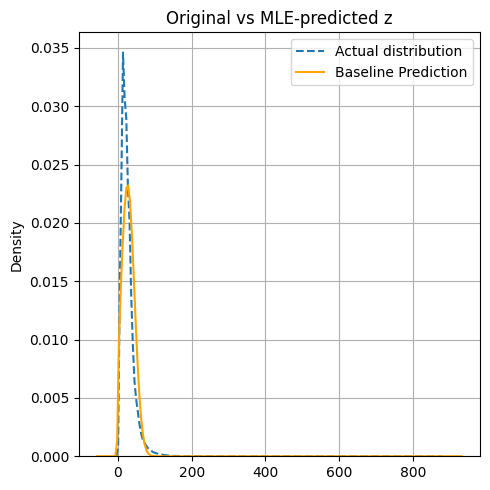

In [ ]:
plt.figure(figsize=(5, 5))

sns.kdeplot(z, linestyle="-.", label="Actual distribution")

z_grid = np.linspace(z.min(), z.max(), z.shape[0])
p = target_pdf(z_grid, c_mle, lambda_mle, mu_mle)
sns.kdeplot(x=z_grid, weights=p, color="orange", label="Baseline Prediction")

plt.title("Original vs MLE-predicted z")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### 2. Training on $log(1 + z)$

`scipy.optimize.curve_fit` estimates the parameters of a nonlinear model by minimizing the **sum of squared residuals** between observed data and model predictions.

By default, it uses the **Levenberg–Marquardt (LM)** algorithm, which is a trust-region method combining **Gauss–Newton** and **gradient descent**.

In [ ]:
# Prepare Histogram Data for Curve Fitting

# We need x-y coordinates: x = bin_centers, y = probability density
hist_values, bin_edges = np.histogram(z, bins=100, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


--- COMPARISON: MLE vs CURVE FIT ---
Lambda (λ): 0.00146 (MLE) vs 0.00349 (Fit)
Mu (μ):     25.80962 (MLE) vs 19.90771 (Fit)
C (c):      0.02156 (MLE) vs 0.03196 (Fit)


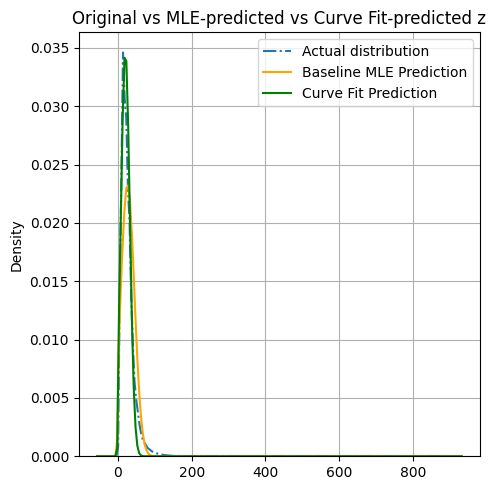

In [ ]:
# Run Optimization (Curve Fitting)

# We provide p0 (initial guesses) from our MLE results to help it converge
initial_guesses = [c_mle, lambda_mle, mu_mle]

try:
    popt, pcov = curve_fit(target_pdf, bin_centers, hist_values, p0=initial_guesses)
    c_fit, lam_fit, mu_fit = popt

    print("\n--- COMPARISON: MLE vs CURVE FIT ---")
    print(f"Lambda (λ): {lambda_mle:.5f} (MLE) vs {lam_fit:.5f} (Fit)")
    print(f"Mu (μ):     {mu_mle:.5f} (MLE) vs {mu_fit:.5f} (Fit)")
    print(f"C (c):      {c_mle:.5f} (MLE) vs {c_fit:.5f} (Fit)")

    # Visual Comparison
    plt.figure(figsize=(5, 5))

    sns.kdeplot(z, linestyle="-.", label="Actual distribution")

    z_grid = np.linspace(z.min(), z.max(), z.shape[0])

    p_mle = target_pdf(z_grid, c_mle, lambda_mle, mu_mle)
    sns.kdeplot(x=z_grid, weights=p_mle, color="orange", label="Baseline MLE Prediction")

    p_fit = target_pdf(z_grid, c_fit, lam_fit, mu_fit)
    sns.kdeplot(x=z_grid, weights=p_fit, color="green", label="Curve Fit Prediction")

    plt.title("Original vs MLE-predicted vs Curve Fit-predicted z")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Curve fitting failed: {e}")

### Step-3: PDF Approximation from Generator Samples

---

After training the GAN:

1. Generate a large number of samples ($z_f$) from the generator

2. Estimate the probability density $p_{h}(z)$ using:
    - Histogram density estimation, **or**
    - Kernel Density Estimation (KDE)

### Step-4: Submission

---

What to Submit
- Transformation parameters ( a_r, b_r )
- GAN architecture description
- PDF plot obtained from GAN samples
- Observations on:
  - Mode coverage
  - Training stability
  - Quality of generated distribution

In [ ]:
submission_lambda = lam_fit
submission_mu = mu_fit
submission_c = c_fit

Submit the values of the parameters (λ, μ and c) through the following link:-

Submission Link: https://forms.gle/jYF3MDKozRnSCHvR8

In [ ]:
# Generating submission.json

data = {
    "rno": r,
    "model_parameters": {
        "lambda": round(submission_lambda, 6),
        "mu": round(submission_mu, 6),
        "c": round(submission_c, 6)
    },
    "metadata": {
        "method": "Levenberg-Marquardt"
    }
}

with open('submission.json', 'w') as f:
    json.dump(data, f, indent=4)

print(">> Generated submission.json!")

NameError: name 'json' is not defined

In [ ]:
# Generating submission.csv

header = ['rno', 'lambda', 'mu']
row = [r, f"{submission_lambda:.6f}", f"{submission_mu:.6f}", f"{submission_c:.6f}"]

with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerow(row)

print(">> Generated submission.csv!")

**Important Instructions**

- **Deadline:** 29 Jan 2026, 11:59 PM
- Late submissions will receive **zero marks**
- Technical issues must be reported **before the deadline**
- **Use of AI-based tools is strictly prohibited**
- Submissions exhibiting AI-generated patterns will be treated as **academic misconduct**
- If AI usage is detected → **Marks = 0**